In [1]:
# import libraries
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

# Ignore specific warning types
warnings.filterwarnings("ignore")

In [2]:
# Load data from the Excel file
data_description = pd.read_excel('Data_Description.xlsx')  # Replace with your actual file path
# Remove the index when writing to a new Excel file

emotion_data_val = data_description[:14].reset_index(drop=True)
transcript_data_val = data_description[16:].reset_index(drop=True)

# Rename the heading (the name of the column)
emotion_data_val.columns = ["Emotion Data","Value"]
transcript_data_val.columns = ["Transcript Data","Value"]

# Print the DataFrame with the updated heading
print(emotion_data_val)
print()
print(transcript_data_val)

        Emotion Data                                              Value
0           movie_id                              Unique ID for a video
1          image_seq                                      Image number 
2              angry                                angry emotion score
3            disgust                              disgust emotion score
4               fear                                 fear emotion score
5              happy                                happy emotion score
6                sad                                  sad emotion score
7           surprise                             surprise emotion score
8            neutral                              neutral emotion score
9   dominant_emotion              dominant emotion among other emotions
10              gaze  Candidate is looking at the camera or not. 1 f...
11             blink              Eye blink (1 -> blink, 0 -> No blink)
12        eye_offset                   Deviation of eye from the

In [3]:
import os
import pandas as pd

# List of file names from '1.csv' to '10.csv'
file_names = [f"{i}.csv" for i in range(1, 11)]

# Specify the folder path where the CSV files are located
transcript_folder_path = 'transcript_data'
emotion_folder_path = 'emotion_data'

# Initialize an empty DataFrame to store the merged data
unfiltered_data = pd.DataFrame()

# Iterate through the list of file names
for file_name in file_names:
    # Construct the full path to the CSV file
    transcript_file_path = os.path.join(transcript_folder_path, file_name)
    emotion_file_path = os.path.join(emotion_folder_path, file_name)
    
    # Read the CSV files into DataFrames
    transcript_data = pd.read_csv(transcript_file_path)
    emotion_data = pd.read_csv(emotion_file_path)
    
    # Removing conflict of 'neutral' by renaming columns to 'neutral_x' and 'neutral_y'
    transcript_data['neutral_x'] = transcript_data.pop('neutral')
    emotion_data['neutral_y'] = emotion_data.pop('neutral')
    
    # Ensure participant_id is unique for every participant
    emotion_data_participant_ids = emotion_data['participant_id'].unique().tolist()
    emotion_data['participant_id'] = emotion_data_participant_ids[0]
    
    for _, row in transcript_data.iterrows():
        # Filter rows based on 'elapsed_time' between 'start' and 'end'
        start_time = row['start']
        end_time = row['end']
        time_condition = (emotion_data['elapsed_time'] >= start_time) & (emotion_data['elapsed_time'] <= end_time)
    
        # Apply the filter to the DataFrame
        filtered_emotion_data = emotion_data[time_condition]
        
        # Check if filtered_emotion_data is empty, and continue to the next iteration if it is
        if filtered_emotion_data.empty:
            continue
        
        # Separate numeric and text columns
        numeric_columns = filtered_emotion_data.select_dtypes(include=['number']).columns
        text_columns = filtered_emotion_data.select_dtypes(include=['object']).columns
        
        # Initialize dictionaries for numeric and text data
        numeric_data_dict = {}
        text_data_dict = {}
        
        if not numeric_columns.empty:
            # Calculate the mean for numeric columns
            numeric_mean_values = filtered_emotion_data[numeric_columns].mean()
            numeric_data_dict = numeric_mean_values.to_dict()
        
        # Create a dictionary to hold all values and initiated it with first word for non numeric data
        result_dict = {'participant_id': filtered_emotion_data['participant_id'].iloc[0], 'movie_id': filtered_emotion_data['movie_id'].iloc[0], 'upload_time': filtered_emotion_data['upload_time'].iloc[0]}
        
        # Update the dictionary with numeric and text data
        result_dict.update(numeric_data_dict)
        
        # Copy all columns from transcript_data to the result_dict
        result_dict.update(row)
        
        # Append the dictionary as a new row to the unfiltered_data DataFrame
        unfiltered_data = unfiltered_data.append(result_dict, ignore_index=True)

# List of emotion characteristics
emotion_characteristics = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral_y"]

# Calculate the column name (emotion) with the maximum value for each row (candidate)
unfiltered_data['dominant_emotion'] = unfiltered_data[emotion_characteristics].idxmax(axis=1)

# Save the unfiltered_data DataFrame to a CSV file
unfiltered_data.to_csv('unfiltered_data.csv', index=False)
print(unfiltered_data)


                           participant_id  \
0    e2aa9258-47a5-46ab-9c5c-283460f7a807   
1    e2aa9258-47a5-46ab-9c5c-283460f7a807   
2    e2aa9258-47a5-46ab-9c5c-283460f7a807   
3    e2aa9258-47a5-46ab-9c5c-283460f7a807   
4    e2aa9258-47a5-46ab-9c5c-283460f7a807   
..                                    ...   
138  70a013ed-120a-41fa-bedd-75a5d15afb76   
139  70a013ed-120a-41fa-bedd-75a5d15afb76   
140  70a013ed-120a-41fa-bedd-75a5d15afb76   
141  70a013ed-120a-41fa-bedd-75a5d15afb76   
142  70a013ed-120a-41fa-bedd-75a5d15afb76   

                                 movie_id          upload_time  image_seq  \
0    93663f94-bf0a-4ce8-a29a-a5236cc7fe6a  2023-09-17 07:58:15       6.50   
1    93663f94-bf0a-4ce8-a29a-a5236cc7fe6a  2023-09-17 07:58:15      12.00   
2    93663f94-bf0a-4ce8-a29a-a5236cc7fe6a  2023-09-17 07:58:15      15.00   
3    93663f94-bf0a-4ce8-a29a-a5236cc7fe6a  2023-09-17 07:58:15      21.25   
4    93663f94-bf0a-4ce8-a29a-a5236cc7fe6a  2023-09-17 07:58:15      24.00 

In [4]:
# filering data
# droping always constant columns
filtered_data = unfiltered_data.drop(columns=['temperature', 'distance'])

# droping always unneccessary columns
filtered_data = filtered_data.drop(columns=['avg_logprob', 'compression_ratio', 'seek', 'upload_time', 'id', 'image_seq', 'movie_id'])

# droping gaze and eye_offset column beacause it looks faulty
filtered_data = filtered_data.drop(columns=['gaze', 'blink'])
print(filtered_data)

                           participant_id      angry   disgust       fear  \
0    e2aa9258-47a5-46ab-9c5c-283460f7a807  18.112995  0.683089  18.021505   
1    e2aa9258-47a5-46ab-9c5c-283460f7a807  19.851160  0.000998   1.657812   
2    e2aa9258-47a5-46ab-9c5c-283460f7a807  16.460270  0.003467   7.055339   
3    e2aa9258-47a5-46ab-9c5c-283460f7a807   7.252213  0.006346   9.691947   
4    e2aa9258-47a5-46ab-9c5c-283460f7a807   4.344490  0.076540   4.499930   
..                                    ...        ...       ...        ...   
138  70a013ed-120a-41fa-bedd-75a5d15afb76   3.149400  0.013218  31.136414   
139  70a013ed-120a-41fa-bedd-75a5d15afb76   1.431026  0.027693  37.534139   
140  70a013ed-120a-41fa-bedd-75a5d15afb76   7.887112  0.032550  30.620650   
141  70a013ed-120a-41fa-bedd-75a5d15afb76   4.045248  0.053637  39.833964   
142  70a013ed-120a-41fa-bedd-75a5d15afb76   0.326095  0.000020   1.177400   

         happy        sad   surprise  eye_offset  elapsed_time  neutral_y  

In [5]:
# counting number of words in the text
filtered_data['word_count'] = filtered_data['text'].str.split().str.len()

# Clearity is extra words spoken or not spoken in a given time
# Clearity = time_duration * probability of speech - words_spoken
filtered_data['clearity'] = abs((filtered_data['end'] - filtered_data['start']) * (1- filtered_data['no_speech_prob']) * filtered_data['speech_speed'] - filtered_data['word_count'])

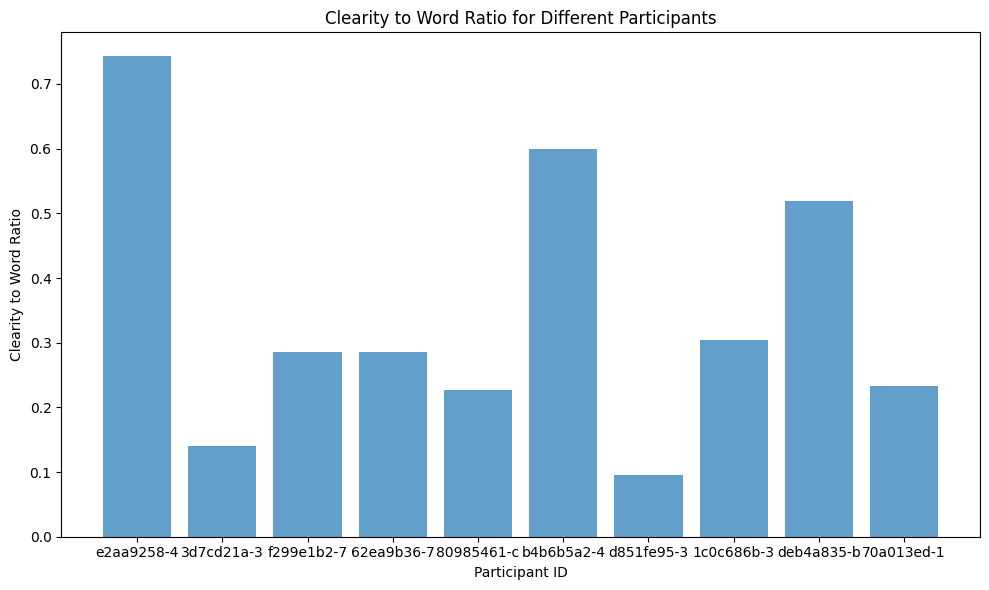

In [6]:

# Create an empty list to store the results for each participant
results = []

participant_ids = filtered_data['participant_id'].unique().tolist()

# Iterate through each participant ID
for participant_id in participant_ids:
    # Filter the DataFrame for the current participant ID
    participant_data = filtered_data[filtered_data['participant_id'] == participant_id]
    
    # Calculate the sum of 'clearance' and 'word_count' for the current participant
    sum_clearance = participant_data['clearity'].sum()
    sum_word_count = participant_data['word_count'].sum()
    
    # Calculate the ratio (sum_clearance / sum_word_count)
    ratio = sum_clearance / sum_word_count
    
    # Create a DataFrame with the participant ID and the ratio
    result_df = pd.DataFrame({'participant_id': [participant_id], 'clearity_word_ratio': [ratio]})
    
    # Append the result to the list of results
    results.append(result_df)

# Concatenate the results into a single DataFrame
final_result = pd.concat(results, ignore_index=True)

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
# Extract the first four digits of each participant ID
shortened_ids = [participant_id[:10] for participant_id in participant_ids]
plt.bar(shortened_ids, final_result['clearity_word_ratio'], alpha=0.7)
plt.xlabel('Participant ID')
plt.ylabel('Clearity to Word Ratio')
plt.title('Clearity to Word Ratio for Different Participants')

# Show the bar plot
plt.tight_layout()  # Ensures the labels are not cut off
plt.show()


In [7]:
# Set the threshold for clearness
threshold = 0.5

# Filter participants with clearness below the threshold
filtered_result = final_result[final_result['clearity_word_ratio'] <= threshold]

# Filter and keep only the rows with participant IDs in the list
filtered_data = filtered_data[filtered_data['participant_id'].isin(filtered_result['participant_id'])]


                         participant_id  eye_offset_error
0  3d7cd21a-3170-4352-b499-24ea04eaf48c         22.791290
1  f299e1b2-7d92-4420-9c5a-d0d2590abdbe         30.336818
2  62ea9b36-7860-4dc9-827c-600604286571         12.283419
3  80985461-c5d6-466f-a30a-4de2784ed0a3         15.802625
4  d851fe95-3ead-47c1-88aa-d6fc453f7021          5.535697
5  1c0c686b-3aae-4ac6-8625-3e86a7a0892f          6.603944
6  70a013ed-120a-41fa-bedd-75a5d15afb76         11.566669


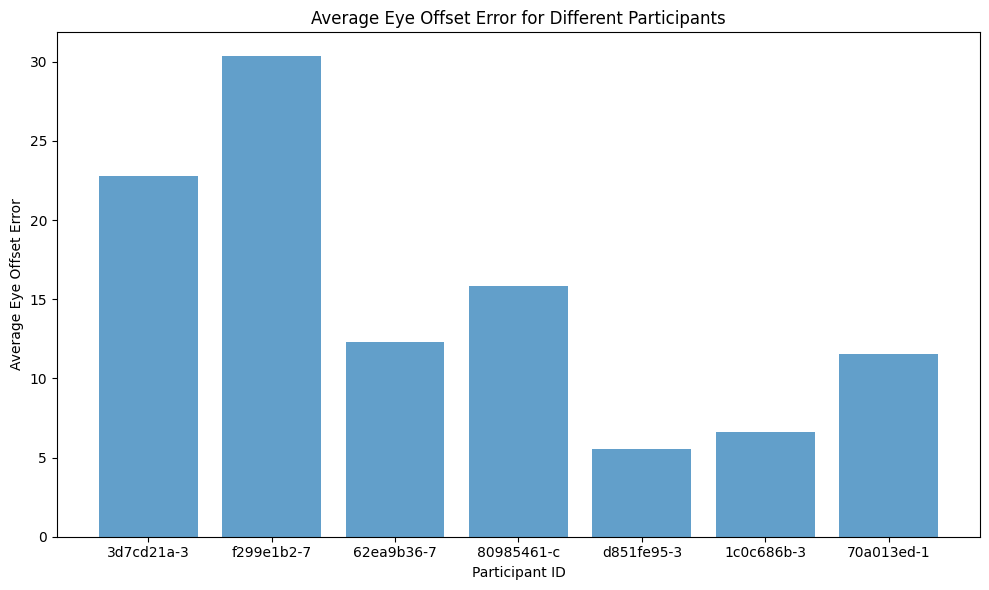

In [8]:

# Create an empty list to store the results for each participant
results = []

participant_ids = filtered_data['participant_id'].unique().tolist()

# Iterate through each participant ID
for participant_id in participant_ids:
    # Filter the DataFrame for the current participant ID
    participant_data = filtered_data[filtered_data['participant_id'] == participant_id]
    
    # Calculate the average of sum of errors in eye_offset
    eye_offset_error = abs(participant_data['eye_offset']).sum() / participant_data.shape[0]
    # Create a DataFrame with the participant ID and the error
    result_df = pd.DataFrame({'participant_id': [participant_id], 'eye_offset_error': [eye_offset_error]})
    
    # Append the result to the list of results
    results.append(result_df)

# Concatenate the results into a single DataFrame
final_result = pd.concat(results, ignore_index=True)
print(final_result)
# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
# Extract the first four digits of each participant ID
shortened_ids = [participant_id[:10] for participant_id in participant_ids]
plt.bar(shortened_ids, final_result['eye_offset_error'], alpha=0.7)
plt.xlabel('Participant ID')
plt.ylabel('Average Eye Offset Error')
plt.title('Average Eye Offset Error for Different Participants')

# Show the bar plot
plt.tight_layout()  # Ensures the labels are not cut off
plt.show()


In [9]:
# Set the threshold for clearness (average elevation of 20 or more means candidate is consistently looking somewhere else)
threshold = 30

# Filter participants with clearness below the threshold
filtered_result = final_result[final_result['eye_offset_error'] <= threshold]

# Filter and keep only the rows with participant IDs in the list
filtered_data = filtered_data[filtered_data['participant_id'].isin(filtered_result['participant_id'])]


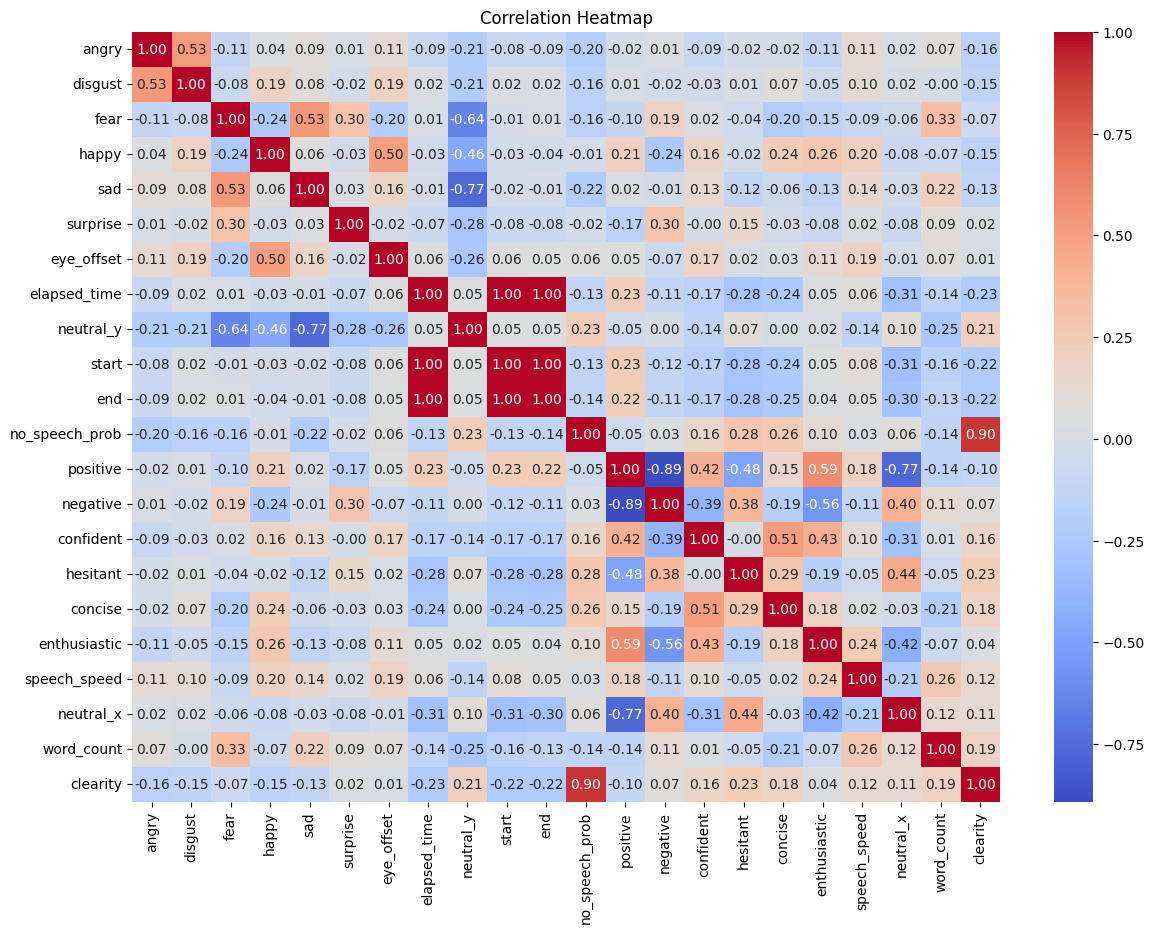

angry              -42.436644
disgust              1.076737
fear               -19.947389
happy               49.363289
sad                 14.929372
surprise           -25.852893
eye_offset         193.007472
elapsed_time      2247.578118
neutral_y           22.867567
start             2268.046059
end               2249.005637
no_speech_prob      -1.581400
positive             3.948961
negative            -1.426775
confident           -2.599352
hesitant            -5.836772
concise             -4.253228
enthusiastic         1.490377
speech_speed         5.907307
neutral_x           -2.522185
word_count         -23.367380
clearity           -48.539244
dtype: float64


In [10]:
# Correlation Analysis
correlation_matrix = filtered_data.drop(columns=['participant_id']).corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()
# Filter for Numeric Columns
numeric_data = filtered_data.select_dtypes(include='number')

# Calculate Covariance Matrix Row Sum
covariance_matrix = numeric_data.cov().sum()

# Display the Covariance Matrix
print(covariance_matrix)

In [11]:
# as we can see disguist is much correlated
filtered_data =  filtered_data.drop(columns=['disgust'])
# Save the unfiltered_data DataFrame to a CSV file
filtered_data.to_csv('filtered_data.csv', index=False)
print(filtered_data)

                           participant_id      angry       fear      happy  \
16   3d7cd21a-3170-4352-b499-24ea04eaf48c  13.138645   2.685987  38.841558   
17   3d7cd21a-3170-4352-b499-24ea04eaf48c   0.671727   2.588321  38.742818   
18   3d7cd21a-3170-4352-b499-24ea04eaf48c  12.145189   7.758884  37.043048   
19   3d7cd21a-3170-4352-b499-24ea04eaf48c   3.530462   8.258549  56.559570   
20   3d7cd21a-3170-4352-b499-24ea04eaf48c  22.218327   2.425954   4.824774   
..                                    ...        ...        ...        ...   
138  70a013ed-120a-41fa-bedd-75a5d15afb76   3.149400  31.136414   3.635207   
139  70a013ed-120a-41fa-bedd-75a5d15afb76   1.431026  37.534139   0.532829   
140  70a013ed-120a-41fa-bedd-75a5d15afb76   7.887112  30.620650   0.441409   
141  70a013ed-120a-41fa-bedd-75a5d15afb76   4.045248  39.833964   0.827605   
142  70a013ed-120a-41fa-bedd-75a5d15afb76   0.326095   1.177400   0.038223   

           sad  surprise  eye_offset  elapsed_time  neutral_y  

In [12]:
# make lists of characteristics of transcript and emotion data
transcript_characteristics = ['positive', 'neutral_x', 'confident', 'hesitant', 'concise', 'enthusiastic']
emotion_characteristics = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral_y']

# Analysing dominance in characteristics of emotion data
final_result = pd.DataFrame(columns=emotion_characteristics)
participant_ids = filtered_data['participant_id'].unique().tolist()
emotion_characteristics.append('participant_id')
# Iterate through each participant ID
for participant_id in participant_ids:
    # Filter the DataFrame for the current participant ID with emotion characteristics
    participant_data = filtered_data[filtered_data['participant_id'] == participant_id]
    participant_data_sum = participant_data[emotion_characteristics].sum()
    
    final_result = final_result.append(participant_data_sum, ignore_index=True)

# Extract the candidate ID, emotions, and the corresponding emotion with the maximum value
dominant_emotion = final_result[['participant_id']]
emotion_characteristics.remove('participant_id')

# Calculate the column name (emotion) with the maximum value for each row (candidate)
dominant_emotion['dominant_emotion'] = final_result[emotion_characteristics].idxmax(axis=1)
print(dominant_emotion)

                                      participant_id dominant_emotion
0  3d7cd21a-3170-4352-b499-24ea04eaf48c3d7cd21a-3...            happy
1  62ea9b36-7860-4dc9-827c-60060428657162ea9b36-7...        neutral_y
2  80985461-c5d6-466f-a30a-4de2784ed0a380985461-c...        neutral_y
3  d851fe95-3ead-47c1-88aa-d6fc453f7021d851fe95-3...             fear
4  1c0c686b-3aae-4ac6-8625-3e86a7a0892f1c0c686b-3...        neutral_y
5  70a013ed-120a-41fa-bedd-75a5d15afb7670a013ed-1...             fear


In [13]:
# Here we can see that two of the participants are having fear as dominant emotion

In [14]:
# Function to get sentiment score using VADER
def get_sentiment_vader(text):
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(text)['compound']

# Function to perform sentiment analysis on the data
def perform_sentiment_analysis(data):
    # Group data by 'participant_id' and aggregate relevant columns
    data_grouped = data.groupby('participant_id').agg({
        'text': ' '.join,  # Concatenate text data
        'angry': 'mean',
        'fear': 'mean',
        'happy': 'mean',
        'sad': 'mean',
        'surprise': 'mean',
        'eye_offset': 'mean'
    }).reset_index()

    # Calculate sentiment scores using VADER and rename a column
    data_grouped['sentiment'] = data_grouped['text'].apply(get_sentiment_vader)
    data_grouped.rename(columns={'eye_offset': 'avg_eye_offset'}, inplace=True)
    
    # Return relevant columns
    return data_grouped[['participant_id', 'sentiment', 'angry', 'fear', 'happy', 'sad', 'surprise', 'avg_eye_offset']]

# Function to calculate scores and add normalized eye offset, emotional attitude, and clarity scores
def calculate_scores(data):
    # Normalize 'avg_eye_offset'
    data['normalized_eye_offset'] = (data['avg_eye_offset'] - data['avg_eye_offset'].min()) / (
        data['avg_eye_offset'].max() - data['avg_eye_offset'].min())

    # Define emotional columns and calculate emotional attitude score
    emotional_columns = ['positive', 'negative', 'confident',
                         'hesitant', 'concise', 'enthusiastic', 'speech_speed', 'neutral_x']
    data['emotional_attitude_score'] = data[emotional_columns].mean(axis=1)
    
    # Rename 'clearity' column to 'clarity_score'
    data['clarity_score'] = 1 - data['clearity'] / data['word_count']
    
    return data

# Define a custom transformer class for weighted scoring
class WeightedScorer(BaseEstimator, TransformerMixin):
    def __init__(self, sentiment_weight=1, emotional_attitude_weight=1, clarity_weight=1, eye_offset_weight=-0.5):
        self.sentiment_weight = sentiment_weight
        self.emotional_attitude_weight = emotional_attitude_weight
        self.clarity_weight = clarity_weight
        self.eye_offset_weight = eye_offset_weight

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Calculate a final score based on weighted attributes
        X['final_score'] = (X['sentiment'] * self.sentiment_weight +
                            X['emotional_attitude_score'] * self.emotional_attitude_weight +
                            X['clarity_score'] * self.clarity_weight +
                            X['normalized_eye_offset'] * self.eye_offset_weight)
        return X

    def score(self, X, y=None):
        # Calculate the mean of 'final_score'
        return np.mean(X['final_score'])

# Load data from a CSV file
data = pd.read_csv('filtered_data.csv')

# Perform sentiment analysis and merge results with the original data
sentiments = perform_sentiment_analysis(data)
data = pd.merge(data, sentiments, on='participant_id', how='left')

# Convert categorical variable 'dominant_emotion' into dummy variables
data = pd.get_dummies(data, columns=['dominant_emotion'], drop_first=True)

# Calculate scores including normalized eye offset, emotional attitude, and clarity
data = calculate_scores(data)

# Define a grid of hyperparameters for grid search
param_grid = {
    'sentiment_weight': np.linspace(0.5, 1.5, 11),
    'emotional_attitude_weight': np.linspace(0.5, 1.5, 11),
    'clarity_weight': np.linspace(0.5, 1.5, 11),
    'eye_offset_weight': np.linspace(-1, 0, 11)
}

# Perform grid search to find the best hyperparameters
grid = GridSearchCV(WeightedScorer(), param_grid, verbose=1,
                    scoring='neg_mean_squared_error', cv=5)
grid.fit(data)
best_weights = grid.best_params_

# Create a final scorer with the best hyperparameters
final_scorer = WeightedScorer(**best_weights)

# Transform the data using the final scorer
data_transformed = final_scorer.transform(data)

# Sort candidates by their final scores in descending order
sorted_candidates = data_transformed.groupby('participant_id').agg(
    {'final_score': 'mean'}).reset_index()
sorted_candidates = sorted_candidates.sort_values(
    by='final_score', ascending=False)['participant_id'].tolist()


Fitting 5 folds for each of 14641 candidates, totalling 73205 fits


In [15]:
print("Best Weights:", best_weights)
print(sorted_candidates)

Best Weights: {'clarity_weight': 0.5, 'emotional_attitude_weight': 0.5, 'eye_offset_weight': -1.0, 'sentiment_weight': 0.5}
['80985461-c5d6-466f-a30a-4de2784ed0a3', 'd851fe95-3ead-47c1-88aa-d6fc453f7021', '1c0c686b-3aae-4ac6-8625-3e86a7a0892f', '70a013ed-120a-41fa-bedd-75a5d15afb76', '62ea9b36-7860-4dc9-827c-600604286571', '3d7cd21a-3170-4352-b499-24ea04eaf48c']


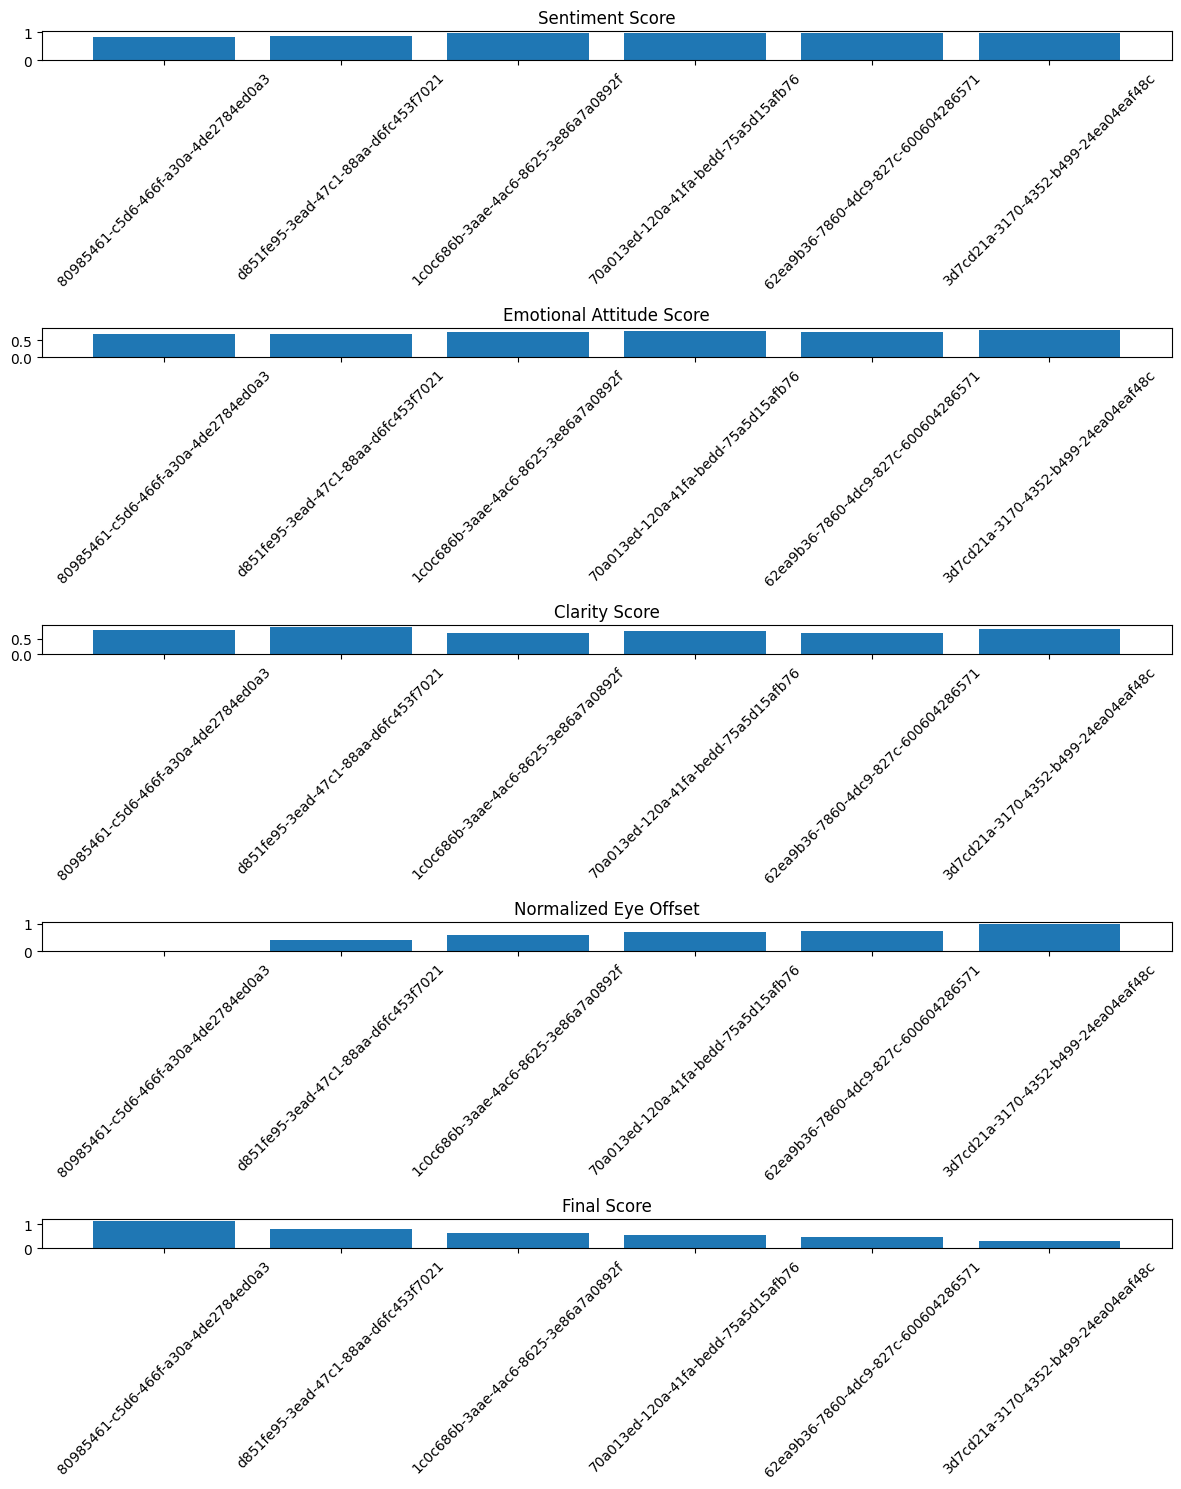

In [16]:
# Grouping the data by 'participant_id' and calculating the mean of various attributes
sorted_candidates_df = data.groupby('participant_id').agg({
    'sentiment': 'mean',
    'emotional_attitude_score': 'mean',
    'clarity_score': 'mean',
    'normalized_eye_offset': 'mean',
    'final_score': 'mean'
}).reset_index()

# Sorting the candidates based on the 'final_score' attribute in descending order
sorted_candidates_df = sorted_candidates_df.sort_values(
    by='final_score', ascending=False)

# Creating a 5x1 grid of subplots with a specified figure size
fig, ax = plt.subplots(5, 1, figsize=(12, 15))

# Define the attributes and corresponding titles for each subplot
attributes = ['sentiment', 'emotional_attitude_score',
              'clarity_score', 'normalized_eye_offset', 'final_score']
titles = ['Sentiment Score', 'Emotional Attitude Score',
          'Clarity Score', 'Normalized Eye Offset', 'Final Score']

# Loop through the attributes and titles to create the bar plots
for i, (attribute, title) in enumerate(zip(attributes, titles)):
    ax[i].bar(sorted_candidates_df['participant_id'],
              sorted_candidates_df[attribute])
    ax[i].set_title(title)
    
    # Rotate the x-axis labels for better readability
    ax[i].tick_params(axis='x', rotation=45)

# Adjust the layout of subplots for better visualization
plt.tight_layout()

# Display the plot
plt.show()


In [17]:
# Calculate the mean final score for each participant_id
mean_final_scores = data_transformed.groupby('participant_id')['final_score'].mean().reset_index()

# Rename the column to 'mean_final_score'
mean_final_scores.rename(columns={'final_score': 'mean_final_score'}, inplace=True)

# Display the mean_final_scores DataFrame
print(mean_final_scores)


                         participant_id  mean_final_score
0  1c0c686b-3aae-4ac6-8625-3e86a7a0892f          0.629806
1  3d7cd21a-3170-4352-b499-24ea04eaf48c          0.312557
2  62ea9b36-7860-4dc9-827c-600604286571          0.481754
3  70a013ed-120a-41fa-bedd-75a5d15afb76          0.551848
4  80985461-c5d6-466f-a30a-4de2784ed0a3          1.158324
5  d851fe95-3ead-47c1-88aa-d6fc453f7021          0.829686
